# PRIMO - The P&A Project Optimizer
## Workflow Demo 

This notebook contains a demo of PRIMO - The P&A Project Optimizer. Utilizing the workflow in the image below, PRIMO reads in  input data on marginal wells and their characteristics and analyzes it with respect to **USER-DEFINED PRIORITIES AND PREFERENCES** to provide recommendations on the design of impactful and efficient P&A projects. 

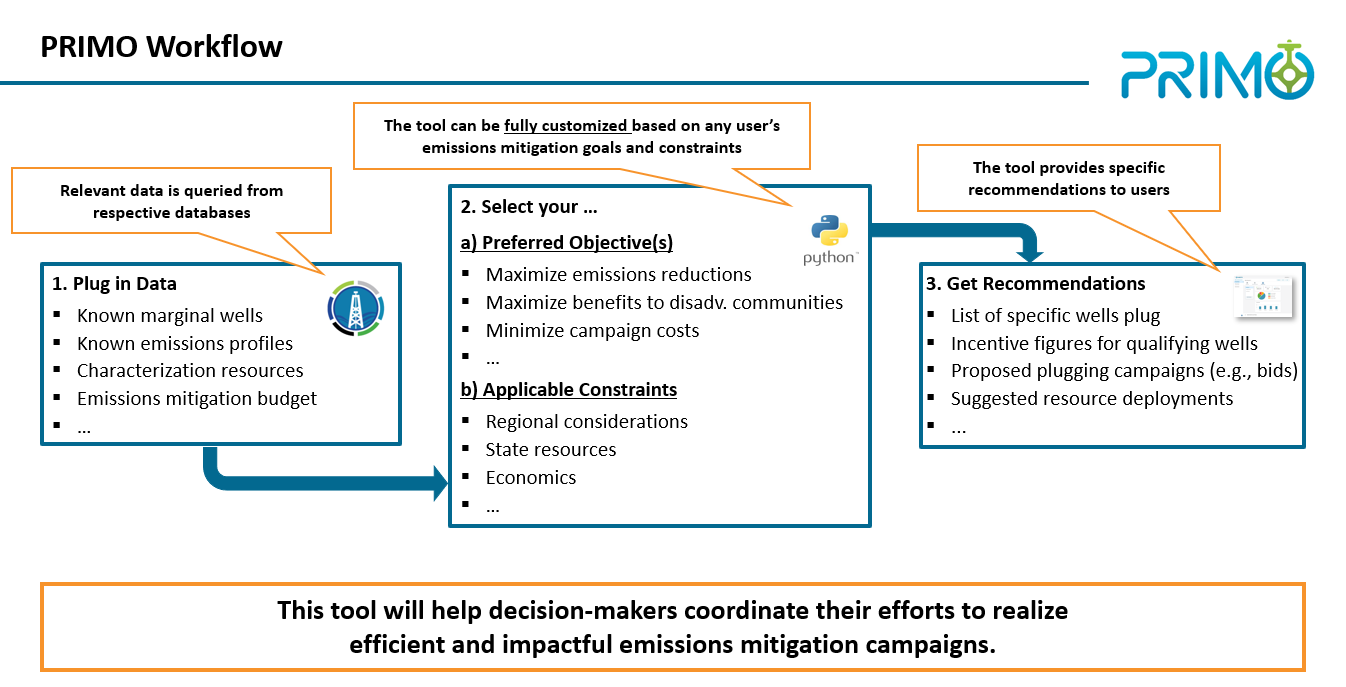

## Priority & Weight Selection Guidelines

Please use the following guidelines when selecting your priorities and their respective weights:
- Use the checkboxes to select preferred priorities and the respective sliders to specify the weight of these 
- Some priorities may also allow for the specification of sub-priorities (e.g., the sensitive receptors priority involves 8 sub-priorities: schools, hospitals, buildings, etc.).
- Use the checkbox to select a sub-priority and the corresponding slider to specify the weight of the sub-priority
- A sub-priority can only be selected if the corresponding "parent" priority has been selected
- The sum of all priorities needs to be 100
- The sum of all sub-priorities within each priority needs to be 100
- If you wish to change the weights after confirming them or getting an error, please re-run this cell in order to get a fresh start

## Using Config File to Provide Inputs

PRIMO utilizes a .json config file to define priority metrics, efficiency metrics, and constraints. Users can also specify default paths for input data files and output files. The current demo includes a config file - [config_Example\_1.json](https://github.com/NEMRI-org/primo-optimizer/blob/main/primo/demo/config_Example_1.json). For detailed guidance on the purpose, construction, and modification of the config file, please refer to the documentation [Config File](https://primo.readthedocs.io/en/latest/method/config_file.html).

## Notice

This demo uses randomized data on a 2-d grid (x and y coordinates). Here, the x-coordinate represents the latitude, and the y-coordinate represents the longitude of a well. The demo results are accordingly visualized in scatter plots. 

PRIMO is designed to process geospatial data containing latitude and longitude information such as shapefiles and also queries data from external sources such as U.S. Census. PRIMO also has utilities available to plot visualizations using maps instead of 2-d grids. 

This notebook is primarily meant to showcase the workflow and functionality of PRIMO. PRIMO is under active development: please reach out to primo@netl.doe.gov for questions, comments, feedback or feature requests.

## Impact Metric Selection

In [1]:
import json
from primo.utils.config_utils import (read_config, read_defaults,
                                      UserPriorities)

HAS_CONFIG, config_dict = read_config(r"config_Example_1.json")

if HAS_CONFIG:
    impact_dict = config_dict["impact_weights"]
priority_weights_default, sub_priority_weights_default = read_defaults(impact_dict)
impact_options = UserPriorities(impact_dict)
display(impact_options.display())

## Efficiency Metric Selection

In [2]:
import json
from primo.utils.config_utils import UserPriorities

if HAS_CONFIG:
    efficiency_dict = config_dict["efficiency_weights"]
efficiency_weights_default, _ = read_defaults(efficiency_dict)
efficiency_options = UserPriorities(efficiency_dict)
display(efficiency_options.display())

In [3]:
priority_weights, sub_priority_weights = impact_options.return_value()
if not priority_weights or not sub_priority_weights:
    priority_weights = priority_weights_default
    sub_priority_weights = sub_priority_weights_default
    
efficiency_weights, _ = efficiency_options.return_value()
if not efficiency_weights:
    efficiency_weights = efficiency_weights_default

In [4]:
import json
from primo.utils.config_utils import UserPriorities

if HAS_CONFIG:
    program_dict = config_dict["program_constraints"]

### Input Data Section

In [5]:
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display, Markdown
import numpy as np
import pandas as pd
from primo.utils.demo_utils import file_path_widget
# Globally configure to only show 2 decimal places everywhere
pd.options.display.float_format = '{:,.2f}'.format

display(Markdown(""" Please use the widgets below to select the file that contains the required information. If default paths are defined in the config.json file, 
                 the widgets will automatically show these paths, avoiding the need for re-selection. If you need to change any
                 of the files, simply click the 'Change' button in the respective widget to select a new file."""))

input_file = file_path_widget("Well Data", ".xlsx", "Well data found", 
                              config_dict.get("Well Data"))

out_str = ""

sensitive_receptors_weight = priority_weights.get('2. Sensitive receptors')
if sensitive_receptors_weight is not None and sensitive_receptors_weight > 0:
    school_weight =  sub_priority_weights['2. Sensitive receptors'].get('2.1 Schools')
    if school_weight is not None and school_weight > 0:
        display(Markdown(""" To provide school locations, please use button below to select or update the file containing them"""))
        school_file = file_path_widget("School Data", ".csv", "School data file found", 
                                       config_dict.get("School Data"))
 
    hospital_weight = sub_priority_weights['2. Sensitive receptors'].get('2.2 Hospitals')
    if hospital_weight is not None and hospital_weight > 0:
        display(Markdown(""" To provide hospital locations, please use button below to select or update the file containing them"""))
        hospital_file = file_path_widget("Hospital Data", ".csv", "Hospital data file found", 
                                         config_dict.get("Hospital Data"))

    

 Please use the widgets below to select the file that contains the required information. If default paths are defined in the config.json file, 
                 the widgets will automatically show these paths, avoiding the need for re-selection. If you need to change any
                 of the files, simply click the 'Change' button in the respective widget to select a new file.

FileChooser(path='C:\codes\primo-optimizer\primo\demo\Example_1_input', filename='Input_example.xlsx', title='…

 To provide school locations, please use button below to select or update the file containing them

FileChooser(path='C:\codes\primo-optimizer\primo\demo\Example_1_input', filename='Schools_example.csv', title=…

 To provide hospital locations, please use button below to select or update the file containing them

FileChooser(path='C:\codes\primo-optimizer\primo\demo\Example_1_input', filename='Hospitals_example.csv', titl…

In [6]:
from primo.utils.demo_utils import get_well_type
from primo.utils.raise_exception import raise_exception

if input_file.selected is None:
    raise_exception("No well data file selected", ValueError)
well_data = pd.read_excel(input_file.selected, "Sheet1")
well_data = well_data.dropna(subset=["x", "y"])

well_data.index = well_data.index + 1
well_data = get_well_type(well_data)
well_data.head()

,API Well Number,Leak [Yes/No],Violation [Yes/No],Incident [Yes/No],Compliance [Yes/No],Oil [bbl/Year],Gas [Mcf/Year],Age [Years],Depth [ft],Elevation Delta [m],Distance to Road [miles],Operator Name,x,y,Well Type
1,41849,No,No,Yes,No,8.27,48.14,66,2277,64,0.93,Owner 56,1.00,1.95,Gas
2,45641,No,No,Yes,Yes,2.87,23.62,68,7942,0,0.45,Owner 136,1.00,1.96,Gas
3,63376,No,No,No,No,8.91,9.88,93,5216,-1,1.00,Owner 137,1.00,1.96,Oil
4,38041,No,No,No,Yes,156.19,0.00,51,4243,2,0.28,Owner 190,1.52,1.96,Oil
5,91117,No,No,Yes,No,7.30,50.94,143,3221,90,0.71,Owner 196,1.52,1.96,Gas


### MCW Population Visualization

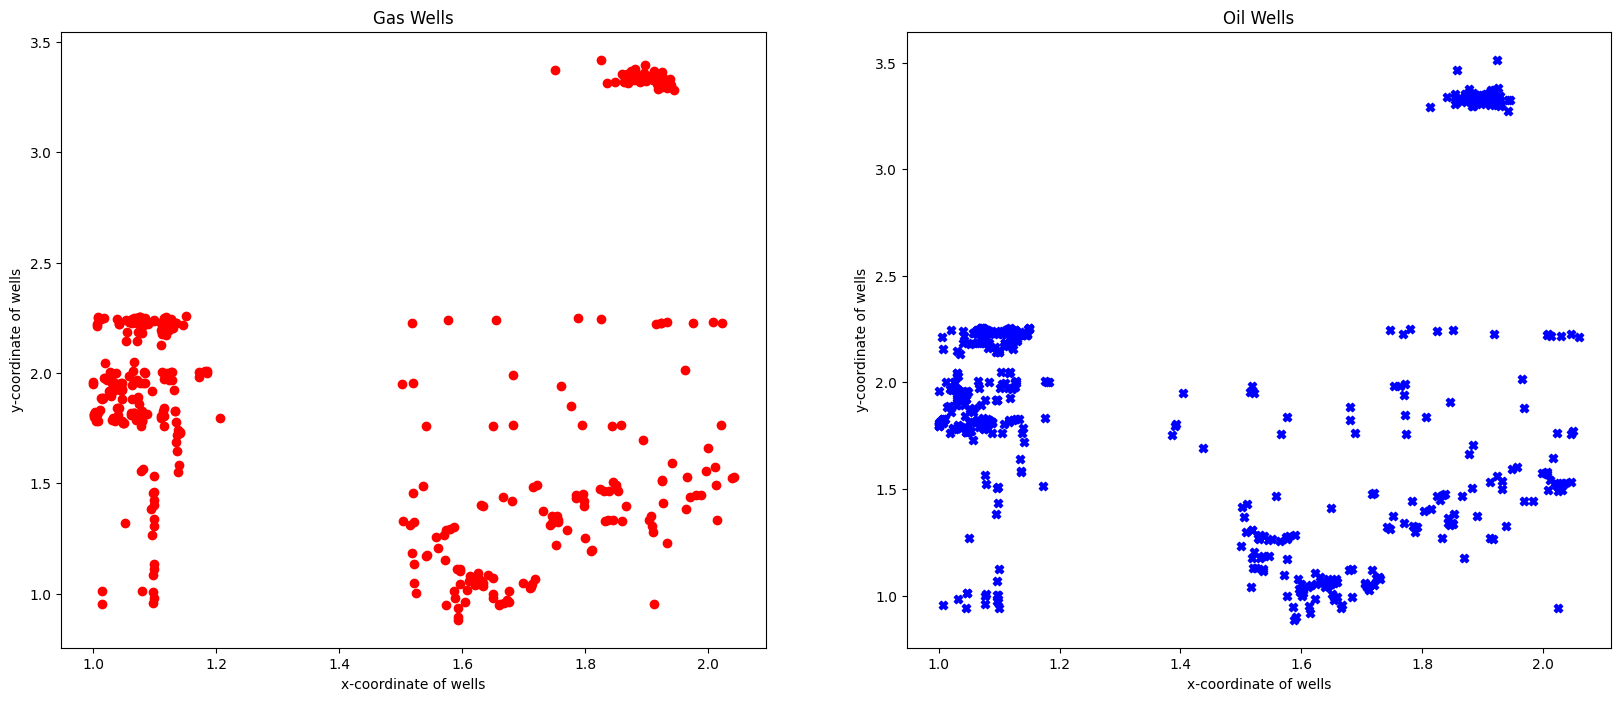

In [7]:
import matplotlib.pyplot as plt
# well_data.plot.scatter(x = 'x', y = 'y')

well_figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

gas_well = well_data[well_data["Well Type"] == "Gas"]
oil_well = well_data[well_data["Well Type"] == "Oil"]
ax1.scatter(gas_well["x"], gas_well["y"], c='r', marker="o")
ax1.set_title('Gas Wells')
ax1.set(xlabel='x-coordinate of wells', ylabel='y-coordinate of wells')
ax2.scatter(oil_well["x"], oil_well["y"], c='b', marker="X")
ax2.set_title('Oil Wells')
ax2.set(xlabel='x-coordinate of wells', ylabel='y-coordinate of wells')
plt.show()

### Capability 1: Prioritizing Wells
The number of wells under consideration is significantly larger than what can be plugged with the budget available. Hence, we prioritize wells as per user-defined priorities to rank the candidate pool of wells.

In [8]:
from IPython.display import display, Markdown
from primo.utils.demo_utils import sort_columns
cols_to_display = ["API Well Number", "Operator Name", "Gas [Mcf/Year]", "Oil [bbl/Year]", 
                   "Well Type", "Age [Years]", "Depth [ft]",  "x", "y"]

gdf = well_data
gdf["Priority Score [0-100]"] = 0 

final_cols_display = []
priority_weight = priority_weights.get('1. Methane Emissions (Proxies)')
if priority_weight is not None:
    display(Markdown("""
#### Prioritizing by (Suspected) Emissions
    
In the absence of emissions readings, we use the following "proxies" to identify wells that are (suspected of) leaking:

* Currently Leaking
* Compliance Reports
* Prior Violations
* Prior Leaks Observed
"""))
    emission_cols = ["Leak [Yes/No]", "Compliance [Yes/No]", "Violation [Yes/No]", "Incident [Yes/No]"]
    col_name = f"Emissions Score [0-{priority_weight}]"
    final_cols_display.append(col_name)
    new_cols_to_display = emission_cols + [col_name]
    sub_weights = sub_priority_weights['1. Methane Emissions (Proxies)']
    gdf[col_name] = 0
    for sub_priority, weight in sub_weights.items():
        col = sub_priority[4:]
        gdf[col] = gdf[col].fillna(0)
        if "Compliance [Yes/No]" in col:
            gdf[col[:-9]] = gdf[col].replace({"NULL": 0, "Yes": 0, "No": 1, pd.NaT: 0})
        else:
            gdf[col[:-9]] = gdf[col].replace({"NULL": 0, "Yes": 1, "No": 0, pd.NaT: 0})
        
        if not np.isclose(weight, 0):
            max_val = gdf[col[:-9]].max()
            min_val = gdf[col[:-9]].min()
            gdf[f"{col} Score"] = (gdf[col[:-9]] - min_val) * 100 / (max_val - min_val)
            gdf[col_name] += gdf[f"{col} Score"]*weight*priority_weight/(10000)
    
    gdf["Priority Score [0-100]"] += gdf[col_name]
    gdf = sort_columns(gdf, {col_name: False})
    
    gdf.index = gdf.index + 1
    display(gdf[cols_to_display + new_cols_to_display].head())


#### Prioritizing by (Suspected) Emissions
    
In the absence of emissions readings, we use the following "proxies" to identify wells that are (suspected of) leaking:

* Currently Leaking
* Compliance Reports
* Prior Violations
* Prior Leaks Observed


,API Well Number,Operator Name,Gas [Mcf/Year],Oil [bbl/Year],Well Type,Age [Years],Depth [ft],x,y,Leak [Yes/No],Compliance [Yes/No],Violation [Yes/No],Incident [Yes/No],Emissions Score [0-35]
1,86095,Owner 65,69.31,0.00,Gas,19,2604,1.08,1.96,Yes,No,No,Yes,28.00
2,84290,Owner 2,992.33,40.15,Gas,84,2261,1.94,3.33,Yes,No,No,Yes,28.00
3,27016,Owner 108,0.00,40.96,Oil,47,1191,1.88,3.31,Yes,No,No,No,24.50
4,76435,Owner 229,0.00,8.77,Oil,30,2667,1.77,1.34,Yes,No,No,No,24.50
5,21133,Owner 53,0.00,4.40,Oil,148,4199,1.06,1.82,No,No,Yes,Yes,21.00


In [9]:
from primo.utils.demo_utils import sort_columns, weight_display
from primo.utils.proximity_utils import nearby_total_school_count, nearby_hospital_count

sensitive_receptors_weight = priority_weights.get('2. Sensitive receptors')
if sensitive_receptors_weight is not None:
    display(Markdown("""
#### Proximity to Sensitive Receptors

Decision-makers have expressed a desire to prioritize wells close to sensitive receptors such as residences, schools or hospitals. 
"""))
    receptor_cols_to_display = []
    col_name = f"Sensitive Receptors Score [0-{sensitive_receptors_weight}]"
    final_cols_display.append(col_name)
    score_cols_to_display = []
    gdf[col_name] = 0
    if school_weight is not None and school_weight > 0:
        if school_file.selected is None:
            raise_exception("No school data file selected", ValueError)
        school_df = pd.read_csv(school_file.selected)
        gdf = nearby_total_school_count(gdf, school_df,
                                        well_coordinates=("x", "y"), 
                                        school_coordinates=("x", "y"),
                                        distance_miles=100)
        gdf["Schools Within Distance"] = gdf["Schools Within Distance"].fillna(0)
        gdf["Schools Within Distance"] = gdf["Schools Within Distance"].replace({pd.NaT: 0})
        max_val = gdf['Schools Within Distance'].max()
        min_val = gdf['Schools Within Distance'].min()
        school_col_name = f"School Score [0-{weight_display(sensitive_receptors_weight*school_weight/100)}]"
        gdf[school_col_name] = (gdf['Schools Within Distance'] - min_val) * school_weight / (max_val - min_val)*sensitive_receptors_weight/100
        gdf[col_name] += gdf[school_col_name]
        receptor_cols_to_display.append('Schools Within Distance')
        score_cols_to_display.append(school_col_name)
        
    if hospital_weight is not None and hospital_weight > 0:
        if hospital_file.selected is None:
            raise_exception("No hospital data file selected", ValueError)
        hospital_df = pd.read_csv(hospital_file.selected)
        gdf = nearby_hospital_count(gdf, hospital_df,
                                    well_coordinates=("x", "y"), 
                                    hospital_coordinates=("x", "y"),
                                    distance_miles=100)
        gdf["Hospitals Within Distance"] = gdf["Hospitals Within Distance"].fillna(0)
        gdf["Hospitals Within Distance"] = gdf["Hospitals Within Distance"].replace({pd.NaT: 0})
        max_val = gdf['Hospitals Within Distance'].max()
        min_val = gdf['Hospitals Within Distance'].min()
        hospital_col_name = f"Hospital Score [0-{weight_display(sensitive_receptors_weight*hospital_weight/100)}]"
        gdf[hospital_col_name] = (gdf['Hospitals Within Distance'] - min_val) * hospital_weight / (max_val - min_val)*sensitive_receptors_weight/100
        gdf[col_name] += gdf[hospital_col_name]
        receptor_cols_to_display.append('Hospitals Within Distance')
        score_cols_to_display.append(hospital_col_name)
    score_cols_to_display.append(col_name)
    receptor_cols_to_display.append(col_name)
    columns = {col_name: False}
    gdf = sort_columns(gdf, columns)
    gdf.index = gdf.index + 1
    gdf["Priority Score [0-100]"] += gdf[col_name]
    
    display(Markdown("""
##### Sensitivity Receptors Indicators

The details for the count of sensitive receptors for a few wells is below.
    
"""))
    display(gdf[cols_to_display[:2] + receptor_cols_to_display].head())


#### Proximity to Sensitive Receptors

Decision-makers have expressed a desire to prioritize wells close to sensitive receptors such as residences, schools or hospitals. 



##### Sensitivity Receptors Indicators

The details for the count of sensitive receptors for a few wells is below.
    


,API Well Number,Operator Name,Schools Within Distance,Hospitals Within Distance,Sensitive Receptors Score [0-20]
1,92936,Owner 206,6,4,18.57
2,43883,Owner 213,6,4,18.57
3,31630,Owner 27,6,4,18.57
4,76973,Owner 41,6,4,18.57
5,56420,Owner 151,6,3,16.07


In [10]:
from IPython.display import display, Markdown

priority_weight = priority_weights.get('3. Production Volumes')
conversion_factor = 5.614583
if priority_weight is not None:
    col_name = f"Production Volumes Score [0-{priority_weight}]"
    final_cols_display.append(col_name)
    new_cols_to_display = []
    gdf[col_name] = 0
    display(Markdown("""
#### Prioritizing by Low Production Volumes
    
We prioritize truly low-producing wells within the MCW population. 
"""))

    gdf["Oil [bbl/Year]"] = gdf["Oil [bbl/Year]"].fillna(0)
    gdf["Gas [Mcf/Year]"] = gdf["Gas [Mcf/Year]"].fillna(0)
    gdf["One-year Production [BOE]"] = gdf["Oil [bbl/Year]"] + gdf["Gas [Mcf/Year]"]/conversion_factor
    max_val = gdf["One-year Production [BOE]"].max()
    min_val = gdf["One-year Production [BOE]"].min()
    one_year_col = f"One-year Production Score [0-{weight_display(priority_weight)}]"
    gdf[one_year_col] = (max_val - gdf["One-year Production [BOE]"]) / (max_val - min_val)*priority_weight
    gdf[col_name] += gdf[one_year_col]
        
    new_cols_to_display.append(col_name)
    gdf["Priority Score [0-100]"] += gdf[col_name]
    columns = {col_name: False}
    gdf = sort_columns(gdf, columns)
    gdf.index = gdf.index + 1
    display(gdf[cols_to_display + new_cols_to_display].head())


#### Prioritizing by Low Production Volumes
    
We prioritize truly low-producing wells within the MCW population. 


,API Well Number,Operator Name,Gas [Mcf/Year],Oil [bbl/Year],Well Type,Age [Years],Depth [ft],x,y,Production Volumes Score [0-20]
1,39839,Owner 57,0.00,0.00,Oil,70,3395,1.93,1.50,20.00
2,80575,Owner 171,0.00,0.00,Oil,95,5591,2.01,2.23,20.00
3,31513,Owner 83,0.00,0.00,Oil,84,10487,1.87,3.32,20.00
4,80864,Owner 22,0.00,0.00,Oil,124,4915,1.88,1.50,20.00
5,71415,Owner 58,0.00,0.00,Oil,103,1431,1.07,2.24,20.00


In [11]:
from IPython.display import display, Markdown
from primo.utils.demo_utils import sort_columns
import math

priority_weight = priority_weights.get('4. Well Age')
if priority_weight is not None:
    display(Markdown("""
#### Prioritizing by Age

There is a preference for older wells for plugging as opposed to younger or newer wells.
"""))
    col_name = f"Well Age Score [0-{priority_weight}]"
    final_cols_display.append(col_name)
    gdf["Age [Years]"] = gdf["Age [Years]"].fillna(0)
    max_val = gdf["Age [Years]"].max()
    min_val = gdf["Age [Years]"].min()
    gdf[col_name] = (gdf["Age [Years]"] - min_val) * priority_weight / (max_val - min_val)
    columns = {col_name: False}
        
    gdf["Priority Score [0-100]"] += gdf[col_name]
    gdf = sort_columns(gdf, columns)
    gdf.index = gdf.index + 1
    display(gdf[cols_to_display + [col_name]].head())


#### Prioritizing by Age

There is a preference for older wells for plugging as opposed to younger or newer wells.


,API Well Number,Operator Name,Gas [Mcf/Year],Oil [bbl/Year],Well Type,Age [Years],Depth [ft],x,y,Well Age Score [0-15]
1,51701,Owner 16,510.95,0.24,Gas,150,11583,1.10,1.27,15.00
2,66882,Owner 69,981.60,26.39,Gas,150,8337,1.05,1.77,15.00
3,89373,Owner 95,7.35,6.78,Oil,150,226,1.03,2.03,15.00
4,73758,Owner 169,95.35,1.33,Gas,150,7053,1.02,1.97,15.00
5,48081,Owner 142,83.43,2.92,Gas,150,8292,1.85,1.33,15.00


In [12]:
from IPython.display import display, Markdown
from primo.utils.demo_utils import sort_columns
import math

priority_weight = priority_weights.get('5. Owner Well-Count')
if priority_weight is not None:
    display(Markdown("""
#### Prioritizing by Owner Well-Count (OWC)

As desired, we prioritize by owner well-count: owners who operate fewer wells will be prioritized. 
"""))
    gdf["Owner Well-Count"] = gdf.groupby("Operator Name")["Operator Name"].transform(
        "size"
    )
    col_name = f"Owner Well-Count Score [0-{priority_weight}]"
    final_cols_display.append(col_name)
    gdf[col_name] = round(priority_weight * gdf["Owner Well-Count"].apply(lambda x: math.e**((1 - x)/10)), 6)
    gdf["Priority Score [0-100]"] += gdf[col_name]
    # Sort columns by priority
    columns = {col_name: False}
    gdf = sort_columns(gdf, columns)
    gdf.index = gdf.index + 1
    display(gdf[cols_to_display + ["Owner Well-Count", col_name]].head())


#### Prioritizing by Owner Well-Count (OWC)

As desired, we prioritize by owner well-count: owners who operate fewer wells will be prioritized. 


,API Well Number,Operator Name,Gas [Mcf/Year],Oil [bbl/Year],Well Type,Age [Years],Depth [ft],x,y,Owner Well-Count,Owner Well-Count Score [0-10]
1,95525,Owner 212,7.31,5.73,Oil,75,9411,1.73,1.08,1,10.00
2,80277,Owner 158,21.78,701.27,Oil,74,2762,1.55,1.19,1,10.00
3,80939,Owner 21,0.00,0.00,Oil,143,4989,1.08,2.24,1,10.00
4,28769,Owner 45,82.43,0.00,Gas,33,3184,1.66,0.95,1,10.00
5,95047,Owner 55,61.78,0.00,Gas,137,6120,1.98,1.45,1,10.00


#### Outstanding: Filtering by MERP Volunteers

The MERP is a voluntary program for well owners.

#### Displaying High-Priority Wells

After applying all previously selected priority calculations, we display the highest-scoring wells below.


In [13]:
columns = {"Priority Score [0-100]": False}
gdf = sort_columns(gdf, columns)
display(Markdown("""
#### Gas Wells by Priority Scores
"""))
top_gas_wells = gdf[gdf["Well Type"] == "Gas"].head(10)
top_gas_wells.index += 1
display(top_gas_wells[cols_to_display[:2] + final_cols_display + ["Priority Score [0-100]"]])


#### Gas Wells by Priority Scores


,API Well Number,Operator Name,Emissions Score [0-35],Sensitive Receptors Score [0-20],Production Volumes Score [0-20],Well Age Score [0-15],Owner Well-Count Score [0-10],Priority Score [0-100]
1,49439,Owner 19,21.00,16.07,19.66,12.58,9.05,78.36
3,84290,Owner 2,28.00,16.07,16.00,8.36,7.41,75.84
5,86095,Owner 65,28.00,16.07,19.77,1.81,6.70,72.36
10,58584,Owner 236,14.00,16.07,19.94,12.08,8.19,70.28
11,21580,Owner 224,21.00,11.07,19.98,13.49,4.49,70.04
12,10241,Owner 188,17.50,16.07,19.11,10.37,6.70,69.75
13,26239,Owner 111,14.00,16.07,19.95,10.57,8.19,68.78
15,21486,Owner 58,14.00,16.07,19.83,12.38,5.49,67.77
16,46413,Owner 51,10.50,16.07,19.48,14.19,7.41,67.65
19,35551,Owner 151,10.50,16.07,19.59,14.50,6.70,67.37


In [14]:
display(Markdown("""
#### Oil Wells by Priority Scores
"""))

top_oil_wells = gdf[gdf["Well Type"] == "Oil"].head(10)
display(top_oil_wells[cols_to_display[:2] + final_cols_display  + ["Priority Score [0-100]"]])
top_oil_wells.index += 1


#### Oil Wells by Priority Scores


,API Well Number,Operator Name,Emissions Score [0-35],Sensitive Receptors Score [0-20],Production Volumes Score [0-20],Well Age Score [0-15],Owner Well-Count Score [0-10],Priority Score [0-100]
1,44388,Owner 137,21.00,16.07,20.00,13.89,6.07,77.03
3,22370,Owner 194,21.00,11.07,19.83,14.40,7.41,73.71
5,55133,Owner 97,14.00,16.07,19.91,12.79,9.05,71.81
6,21133,Owner 53,21.00,8.57,19.92,14.80,7.41,71.70
7,36524,Owner 238,14.00,16.07,19.68,11.17,10.00,70.93
8,62214,Owner 117,14.00,16.07,19.91,13.59,6.70,70.28
13,38073,Owner 154,14.00,16.07,19.34,10.57,8.19,68.17
16,74642,Owner 189,14.00,11.07,19.14,14.19,9.05,67.45
17,57746,Owner 33,14.00,16.07,19.99,9.97,7.41,67.43
21,27084,Owner 104,14.00,11.07,19.68,13.89,8.19,66.84


### Clustering Wells to Identify High-Impact, High-Efficiency P&A Candidate Projects
At present, wells are clustered based on proximity and similarity in characteristics (e.g. well age) so they can be organized into IMPACTFUL and EFFICIENT P&A projects. To identify groups of wells that would form a promising set for a project, we apply a constrained clustering algorithm.

In [15]:
import numpy as np
import pandas as pd
from primo.utils.clustering_utils import distance_matrix
from sklearn.cluster import AgglomerativeClustering

oil_gdf = gdf[gdf['Well Type']== 'Oil']
gas_gdf = gdf[gdf['Well Type']== 'Gas']
oil_gdf.rename(columns={"x": "Latitude","y": "Longitude"}, inplace = True)
gas_gdf.rename(columns={"x": "Latitude", "y": "Longitude"}, inplace = True)

# Set of wells and the weights chosen for clustering
oil_candidates = oil_gdf[["Latitude", "Longitude", "Age [Years]", "Depth [ft]"]]
gas_candidates = gas_gdf[["Latitude", "Longitude", "Age [Years]", "Depth [ft]"]]


weights = {"distance": 0.9899, "age": 0.01, "depth": 0.0001}


distance_metric_oil = distance_matrix(oil_candidates, weights)
oil_clustering = AgglomerativeClustering(n_clusters=None, metric='precomputed', linkage='complete', distance_threshold=10).fit(distance_metric_oil)

distance_metric_gas = distance_matrix(gas_candidates, weights)
gas_clustering = AgglomerativeClustering(n_clusters=None, metric='precomputed', linkage='complete', distance_threshold=10).fit(distance_metric_gas)

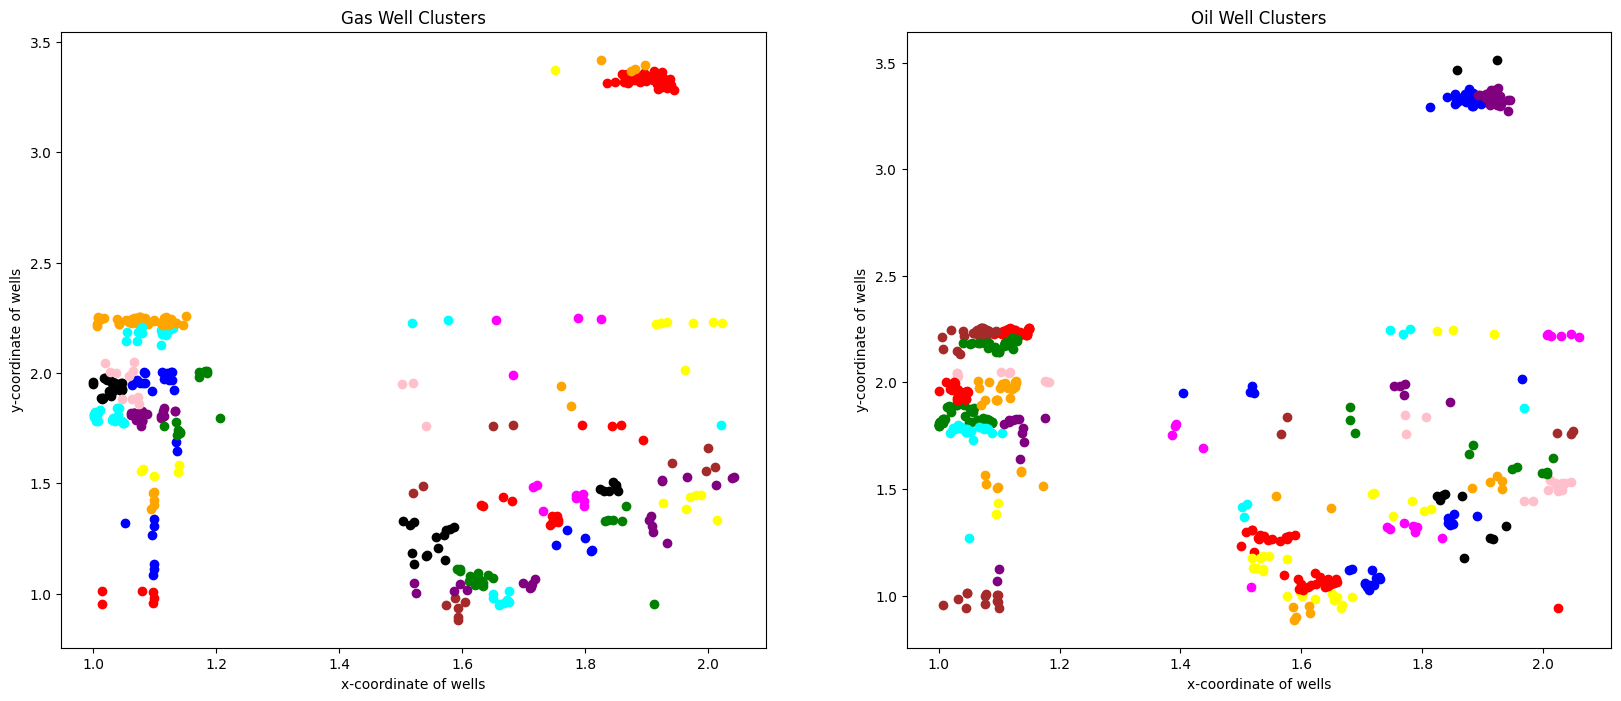

In [16]:
from primo.utils.map_utils import get_cluster_colors

n_clusters_gas = gas_clustering.n_clusters_
n_clusters_oil = oil_clustering.n_clusters_

oil_candidates['cluster'] = oil_clustering.labels_ + n_clusters_gas
oil_candidates["API Well Number"] = oil_gdf["API Well Number"]

gas_candidates['cluster'] = gas_clustering.labels_
gas_candidates["API Well Number"] = gas_gdf["API Well Number"]

color_list_oil = get_cluster_colors(n_clusters_oil, pd.unique(oil_candidates["cluster"]))
color_list_gas = get_cluster_colors(n_clusters_gas, pd.unique(gas_candidates["cluster"]))

oil_gdf["cluster"] = oil_candidates["cluster"]
gas_gdf["cluster"] = gas_candidates["cluster"]


cluster_figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

for cluster in color_list_gas:
    gas_cluster = gas_gdf[gas_gdf["cluster"] == cluster]
    ax1.scatter(gas_cluster["Latitude"], gas_cluster["Longitude"], c=color_list_gas[cluster])
ax1.set_title('Gas Well Clusters')
ax1.set(xlabel='x-coordinate of wells', ylabel='y-coordinate of wells')

for cluster in color_list_oil:
    oil_cluster = oil_gdf[oil_gdf["cluster"] == cluster]
    ax2.scatter(oil_cluster["Latitude"], oil_cluster["Longitude"], c=color_list_oil[cluster])
ax2.set_title('Oil Well Clusters')
ax2.set(xlabel='x-coordinate of wells', ylabel='y-coordinate of wells')
plt.show()


In [17]:
oil_gdf["Well ID"] = oil_gdf["API Well Number"]
gas_gdf["Well ID"] = gas_gdf["API Well Number"]
oil_gdf["cluster"] = "Cluster " + oil_candidates["cluster"].astype(str)
gas_gdf["cluster"] = "Cluster " + gas_candidates["cluster"].astype(str)
oil_gdf.to_csv("Example_1_top_wells_oil.csv", index=False)
gas_gdf.to_csv("Example_1_top_wells_gas.csv", index=False)

## Capability 2: Budget-Specific P&A Projects Optimization 
To determine high-impact, high-efficiency P&A within the available budget, we use an optimization model. The optimization carefully evaluates all possible combinations of wells for plugging projects and helps us select the best campaigns in a data-based, transparent and defensible way.

The goal of the optimization is to seek those P&A projects that are not only impactful but will also lead to the most efficient use of P&A resources. The impact of a P&A project is determined by the priority scores of the wells contained within (as per the calculations outline above). More information on the definition and calculation of the predicted efficiency of a P&A project is provided below.

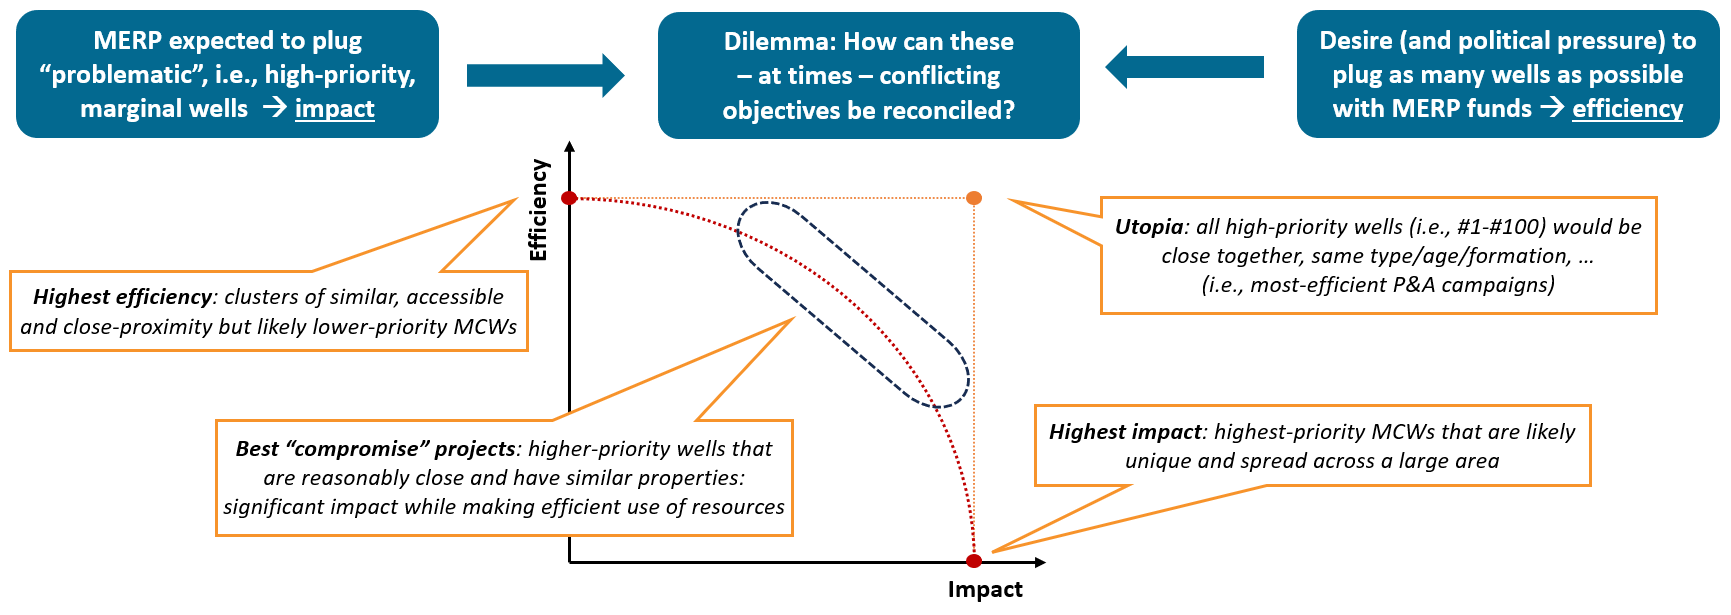

### State-Wide Program Constraints

In [18]:
program_weights_default, _ = read_defaults(program_dict)
program_options = UserPriorities(program_dict, validate=False)
display(program_options.display())

In [19]:
program_weights, _ = program_options.return_value()
if not program_weights:
    program_weights = program_weights_default

In [20]:
arg_list_cond = []

max_wells_per_owner = program_weights.get("Owner Well Count Constraint")
if max_wells_per_owner is not None:
    arg_list_cond+=["-owc", str(max_wells_per_owner)]

### Optimizing for P&A Gas Projects 

In [21]:
# Update Path so appropriate PRIMO modules can be imported
import os
from pathlib import Path
import sys
from primo.data_parser.input_parser import InputParser 
from primo.opt_model.opt_model import OptModel
from primo.utils.setup_arg_parser import parse_args
from primo.utils.setup_logger import setup_logger
import pandas as pd


oil_gdf = pd.read_csv("Example_1_top_wells_oil.csv")
gas_gdf = pd.read_csv("Example_1_top_wells_gas.csv")


total_budget = program_weights["Total Budget"]

gas_budget = total_budget*len(gas_gdf)/(len(oil_gdf) + len(gas_gdf))
verbose_output = 0

# TODO: Add ipywidgets for these input parameters
# Mobilization cost for a campaign as a function of the number of wells in a campaign
mobilization_costs = {0: 0, 1: 120000, 2: 210000, 3: 280000, 4: 350000}
for n_wells in range(5, len(gas_gdf)):
    mobilization_costs[n_wells] = n_wells * 84000

arg_list = ["-f", "Example_1_top_wells_gas.csv", "-b", str(gas_budget), "-v", str(verbose_output)]
arg_list+=arg_list_cond

args = parse_args(arg_list)

# Set up logger
setup_logger(1, False)

parser = InputParser(args)
opt_inputs_gas = parser.parse_data(mobilization_costs)

# Now create and solve the optimization model
model = OptModel("PRIMO Model for Gas Wells", opt_inputs_gas)
model.build_model()

status = model.solve_model(
    {"solver": "scip"}
)
assert status, "Feasible/Optimal solution not found"

print("")
selected_gas_wells = model.get_results()

SCIP version 9.1.0 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: Soplex 7.1.0] [GitHash: 8cab0278ba]
Copyright (c) 2002-2024 Zuse Institute Berlin (ZIB)

External libraries: 
  Soplex 7.1.0         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 595bfac9]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (github.com/coin-or/CppAD)
  ZLIB 1.3.1           General purpose compression library by J. Gailly and M. Adler (zlib.net)
  MPIR 3.0.0           Multiple Precision Integers and Rationals Library developed by W. Hart (mpir.org)
  ZIMPL 3.6.1          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  AMPL/MP 690e9e7      AMPL .nl file reader library (github.com/ampl/mp)
  PaPILO 2.3.0         parallel presolve for integer and linear optimization (github.com/scipopt/papilo) (built with TBB) [GitHash: 4b8ce6ed]
  Nauty 2.8.8          Computing Graph Autom

### Optimizing for P&A Oil Projects

In [22]:
# Update Path so appropriate PRIMO modules can be imported
import os
from pathlib import Path
import sys

from primo.data_parser.input_parser import InputParser
from primo.opt_model.opt_model import OptModel
from primo.utils.setup_arg_parser import parse_args
from primo.utils.setup_logger import setup_logger

# Parameters
oil_budget = total_budget*len(oil_gdf)/(len(oil_gdf) + len(gas_gdf))
verbose_output = 0

# TODO: Add ipywidgets for these input parameters
# Mobilization cost for a campaign as a function of the number of wells in a campaign
mobilization_costs = {0: 0, 1: 120000, 2: 210000, 3: 280000, 4: 350000}
for n_wells in range(5, len(oil_gdf)):
    mobilization_costs[n_wells] = n_wells * 84000


arg_list = ["-f", "Example_1_top_wells_oil.csv", "-b", str(oil_budget), "-v", str(verbose_output)]
arg_list+=arg_list_cond

args = parse_args(arg_list)

# Set up logger
setup_logger(1, False)

parser = InputParser(args)
opt_inputs_oil = parser.parse_data(mobilization_costs)

# Now create and solve the optimization model
model = OptModel("PRIMO Model for Oil Wells", opt_inputs_oil)
model.build_model()

status = model.solve_model(
    {"solver": "scip"}
)
assert status, "Feasible/Optimal solution not found"

print("")
selected_oil_wells = model.get_results()

SCIP version 9.1.0 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: Soplex 7.1.0] [GitHash: 8cab0278ba]
Copyright (c) 2002-2024 Zuse Institute Berlin (ZIB)

External libraries: 
  Soplex 7.1.0         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 595bfac9]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (github.com/coin-or/CppAD)
  ZLIB 1.3.1           General purpose compression library by J. Gailly and M. Adler (zlib.net)
  MPIR 3.0.0           Multiple Precision Integers and Rationals Library developed by W. Hart (mpir.org)
  ZIMPL 3.6.1          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  AMPL/MP 690e9e7      AMPL .nl file reader library (github.com/ampl/mp)
  PaPILO 2.3.0         parallel presolve for integer and linear optimization (github.com/scipopt/papilo) (built with TBB) [GitHash: 4b8ce6ed]
  Nauty 2.8.8          Computing Graph Autom

In [23]:
if not selected_gas_wells:
    raise ValueError("Zero gas wells are selected for P&A projects")

if not selected_oil_wells:
    raise ValueError("Zero oil wells are selected for P&A projects")


### RESULT: Summary of PRIMO-Recommended High-Impact, High-Efficiency P&A Gas Projects

In [24]:
# The maximum "Number of wells" and "Number of unique owners" for a well is set as the maximum value among all selected projects.
# The setup may need to be revisited.

gas_gdf["selected"] = gas_gdf.apply(
    lambda row: "1" if row["Well ID"] in selected_gas_wells else "0", axis=1
)
selected_gas = gas_gdf[gas_gdf["selected"] == "1"]

oil_gdf["selected"] = oil_gdf.apply(
    lambda row: "1" if row["Well ID"] in selected_oil_wells else "0", axis=1
)
selected_oil = oil_gdf[oil_gdf["selected"] == "1"]


selected_wells = pd.concat([selected_gas, selected_oil])
cluster_selected_wells_len = selected_wells.groupby("cluster")
max_len = []
max_owner = []
for cluster, group in cluster_selected_wells_len:
    max_len.append(len(group[["API Well Number"]]))
    max_owner.append(len(group.groupby("Operator Name")))

max_val_col = {
    "Average Elevation Delta [m]": well_data["Elevation Delta [m]"].max(),  
    "Number of Wells": max(max_len),
    "Number of Unique Owners": max(max_owner),  
    "Average Distance to Road [miles]": well_data["Distance to Road [miles]"].max(), 
    "Distance to Centroid [miles]": 5,  
    "Age Range [Years]": well_data["Age [Years]"].max(),
    "Average Age [Years]": well_data["Age [Years]"].max(),   
    "Depth Range [ft]": well_data["Depth [ft]"].max(), 
    "Average Depth [ft]": well_data["Depth [ft]"].max(),
}

min_val_col = {
    "Average Elevation Delta [m]": well_data["Elevation Delta [m]"].min(),
    "Number of Wells": 1,
    "Number of Unique Owners": 1,  
    "Average Distance to Road [miles]": well_data["Distance to Road [miles]"].min(), 
    "Distance to Centroid [miles]": 0,  
    "Age Range [Years]": well_data["Age [Years]"].min(),
    "Average Age [Years]": well_data["Age [Years]"].min(),   
    "Depth Range [ft]": well_data["Depth [ft]"].min(), 
    "Average Depth [ft]": well_data["Depth [ft]"].min(),
}

columns = {
    "Number of Wells": True,
    "Number of Unique Owners": False,  
    "Average Elevation Delta [m]": False,  
    "Average Distance to Road [miles]": False, 
    "Distance to Centroid [miles]": False,  
    "Age Range [Years]": False,
    "Average Age [Years]": False,   
    "Depth Range [ft]": False, 
    "Average Depth [ft]": False,
}

criterion = [
    "Number of Wells",
    "Number of Unique Owners", 
    "Average Elevation Delta [m]",  
    "Average Distance to Road [miles]", 
    "Distance to Centroid [miles]",  
    "Age Range [Years]", 
    "Average Age [Years]",  
    "Depth Range [ft]",
    "Average Depth [ft]" 
]

def reset_scores_if_single_well(row, col):
    project_criterion = [
    "Distance to Centroid [miles]",  
    "Age Range [Years]", 
    "Average Age [Years]",  
    "Depth Range [ft]",
    "Average Depth [ft]",
    "Number of Unique Owners" 
]
    if row["Number of Wells"] == 1 and col in project_criterion:
        row[f"{col} Score [0 - {efficiency_weights[col]}]"] = 0
    return row

def reset_scores_if_average_is_nan(row, col):
    project_criterion = [
    "Average Age [Years]",  
    "Average Depth [ft]",
    "Average Elevation Delta [m]",  
    "Average Distance to Road [miles]",
]
    if np.isnan(row[col]) and col in project_criterion:
        row[f"{col} Score [0 - {efficiency_weights[col]}]"] = 0
    return row

In [25]:
import numpy as np
from primo.utils.geo_utils import get_distance
from primo.utils.elevation_utils import get_elevation_delta, get_nearest_road_point
from primo.utils.kpi_utils import process_data


gas_gdf["selected"] = gas_gdf.apply(
    lambda row: "1" if row["Well ID"] in selected_gas_wells else "0", axis=1
)

gas_gdf.rename(columns={"Census Tract ID": "Geoid"}, inplace=True)
gas_gdf.rename(columns={"cluster": "Project"}, inplace = True)

gas_gdf["Project"] = gas_gdf.apply(lambda row: str(int(row["Project"][8:])), axis=1)
gas_gdf['Project'] = gas_gdf['Project'].str.replace('Cluster', 'Project')

selected_gas = gas_gdf[gas_gdf["selected"] == "1"]


idx = -1
resulting_contracts = []
total_cost = 0
grouped_contracts = []
for cluster_id, groups in selected_gas.groupby("Project"):
    idx += 1
    n_wells = len(groups)
    campaign_cost = mobilization_costs[n_wells]
    total_cost += campaign_cost
    cluster = "Project " + cluster_id
    grouped_contracts += [[cluster, f"{campaign_cost:,}", n_wells]]
    for _, row in groups.iterrows():
        new_row = [cluster, row["API Well Number"], f"{campaign_cost:,}", n_wells]
        resulting_contracts += [new_row]

results = pd.DataFrame(
    resulting_contracts,
    columns=[
        "Project ID",
        "API Well Number",
        "Estimated Project Cost",
        "Wells in Campaign",
    ],
)


###Efficiency calculation

gas_wells = selected_gas[['API Well Number', 'Operator Name', 'Age [Years]', 'Depth [ft]', 'Latitude', 'Longitude', 'Priority Score [0-100]', 'Project', "Distance to Road [miles]",
        "Elevation Delta [m]",]]

gas_wells = gas_wells.sort_values(by='Project')

cluster_groups = gas_wells.groupby('Project')

centroids = {}

# Iterate over each cluster group
for cluster, group in cluster_groups:
    centroid = tuple(np.round(np.mean(group[['Latitude', 'Longitude']].values, axis=0), 6))
    centroids[cluster] = centroid

# Create a new column 'Cluster Centroid' by mapping the centroids dictionary
gas_wells['Project Centroid'] = gas_wells['Project'].map(centroids)

gas_wells['Distance to Centroid [miles]'] = gas_wells.apply(lambda row: get_distance((row['Latitude'], row['Longitude']), row['Project Centroid']), axis=1)

new_df_gas = process_data(gas_wells, centroids)
cols_to_display = list(new_df_gas.columns)

cols_to_display.remove("Impact Score [0-100]")

cols_to_display = ["Project", "Project Centroid"]

new_df_gas["Efficiency Score [0-100]"] = 0
# Convert all criterion to scores
for col in criterion & efficiency_weights.keys():
    
    if col in ["Number of Wells"]:
        new_df_gas[f"{col} Score [0 - {efficiency_weights[col]}]"] = (new_df_gas[col] - min_val_col[col]) * efficiency_weights[col] / (max_val_col[col] - min_val_col[col])
        cols_to_display.append(f"{col} Score [0 - {efficiency_weights[col]}]")
    if col in [
    "Average Elevation Delta [m]",  
    "Average Distance to Road [miles]", 
    "Distance to Centroid [miles]",  
    "Age Range [Years]", 
    "Average Age [Years]",  
    "Depth Range [ft]",
    "Average Depth [ft]",
    "Number of Unique Owners" 
]:
        new_df_gas[f"{col} Score [0 - {efficiency_weights[col]}]"] = (max_val_col[col] - new_df_gas[col]) * efficiency_weights[col] / (max_val_col[col] - min_val_col[col])
        cols_to_display.append(f"{col} Score [0 - {efficiency_weights[col]}]")
    
    new_df_gas = new_df_gas.apply(lambda row: reset_scores_if_single_well(row, col), axis=1)
    new_df_gas = new_df_gas.apply(lambda row: reset_scores_if_average_is_nan(row, col), axis=1)
    new_df_gas["Efficiency Score [0-100]"] += new_df_gas[f"{col} Score [0 - {efficiency_weights[col]}]"]

acc_criterion = ["Average Elevation Delta [m]",  "Average Distance to Road [miles]",]
ac_weight = 0
for ac_col in acc_criterion & efficiency_weights.keys():
    ac_weight += efficiency_weights[ac_col]
new_df_gas[f'Accessibility Score [0 - {ac_weight}]'] = 0
for ac_col in acc_criterion & efficiency_weights.keys():
    new_df_gas[f'Accessibility Score [0 - {ac_weight}]'] += new_df_gas[f'{ac_col} Score [0 - {efficiency_weights[ac_col]}]']
    cols_to_display.remove(f"{ac_col} Score [0 - {efficiency_weights[ac_col]}]")
if ac_weight > 0:
    cols_to_display.append(f'Accessibility Score [0 - {ac_weight}]')

cols_to_display.append("Efficiency Score [0-100]")

new_df_gas = new_df_gas.sort_values(by="Efficiency Score [0-100]", ascending=False)


grouped_gas = pd.DataFrame(
    grouped_contracts,
    columns=["Project ID", "Estimated Project Cost", "Wells in Project"],
)

blankIndex=[''] * len(new_df_gas)
new_df_gas.index=blankIndex

display(new_df_gas[["Project", "Number of Wells", "Impact Score [0-100]", "Efficiency Score [0-100]"]])
print(f"Total budget recommended for plugging gas wells is: {total_cost:,}")


,Project,Number of Wells,Impact Score [0-100],Efficiency Score [0-100]
,2,17,67.23,53.57
,18,6,66.25,52.43
,9,5,64.26,43.73
,14,5,64.62,42.58
,5,5,63.41,40.90


Total budget recommended for plugging gas wells is: 3,192,000


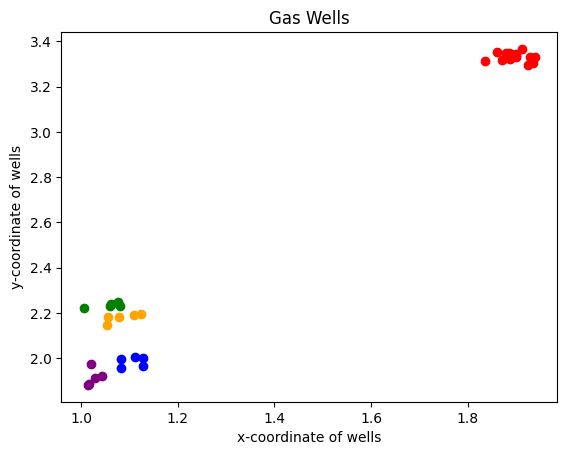

In [26]:
color_list_gas = get_cluster_colors(len(selected_gas.groupby("Project")), pd.unique(selected_gas["Project"]))

gas_figure = plt.figure()
ax1 = gas_figure.add_subplot(111)

for cluster in color_list_gas:
    gas_cluster = selected_gas[selected_gas["Project"] == cluster]
    ax1.scatter(gas_cluster["Latitude"], gas_cluster["Longitude"], c=color_list_gas[cluster])
plt.title('Gas Wells')
plt.xlabel('x-coordinate of wells')
plt.ylabel('y-coordinate of wells')
plt.show()

In [27]:
def wells_in_project(df, project_id, df_pro):
    subset = df[(df["Project"] == f"{project_id}") & (df["selected"] == "1")]
    cols_to_keep = [
        "Project",
        "API Well Number",
        "Operator Name",
        "Gas [Mcf/Year]",
        "Oil [bbl/Year]",
        "Age [Years]",
        "Depth [ft]",
        "Priority Score [0-100]",
    ]
    subset = subset[cols_to_keep]
    project_efficiency_score = float(df_pro[df_pro["Project"] == f"{project_id}"]["Efficiency Score [0-100]"])
    subset["Project Efficiency Score [0-100]"] = project_efficiency_score
    return subset
for i in grouped_gas['Project ID']:
    print(f"The following wells are in {i}")
    cluster = int(i[7:])
    display(wells_in_project(selected_gas, cluster, new_df_gas))

The following wells are in Project 14


,Project,API Well Number,Operator Name,Gas [Mcf/Year],Oil [bbl/Year],Age [Years],Depth [ft],Priority Score [0-100],Project Efficiency Score [0-100]
2,14,86095,Owner 65,69.31,0.00,19,2604,72.36,42.58
28,14,56351,Owner 69,82.46,7.58,137,11819,65.06,42.58
40,14,62920,Owner 86,526.37,7.97,114,6564,63.62,42.58
61,14,53625,Owner 1,166.44,9.83,90,1920,61.49,42.58
73,14,11406,Owner 196,54.27,0.00,125,10037,60.58,42.58


The following wells are in Project 18


,Project,API Well Number,Operator Name,Gas [Mcf/Year],Oil [bbl/Year],Age [Years],Depth [ft],Priority Score [0-100],Project Efficiency Score [0-100]
5,18,10241,Owner 188,226.63,8.05,104,1794,69.75,52.43
15,18,84951,Owner 240,500.33,0.00,148,7900,66.41,52.43
20,18,54792,Owner 61,319.92,36.70,148,6439,65.55,52.43
21,18,57844,Owner 66,9.32,0.00,150,1140,65.53,52.43
23,18,37637,Owner 59,87.72,0.00,90,6487,65.43,52.43
34,18,79899,Owner 29,9.71,0.00,116,1766,64.80,52.43


The following wells are in Project 2


,Project,API Well Number,Operator Name,Gas [Mcf/Year],Oil [bbl/Year],Age [Years],Depth [ft],Priority Score [0-100],Project Efficiency Score [0-100]
0,2,49439,Owner 19,53.36,9.10,126,1781,78.36,53.57
1,2,84290,Owner 2,992.33,40.15,84,2261,75.84,53.57
3,2,58584,Owner 236,18.97,0.00,121,12639,70.28,53.57
6,2,26239,Owner 111,16.25,0.00,106,12852,68.78,53.57
7,2,21486,Owner 58,42.46,1.87,124,10416,67.77,53.57
9,2,35551,Owner 151,105.92,3.16,145,6845,67.37,53.57
12,2,73984,Owner 142,87.46,5.70,122,3796,66.83,53.57
14,2,97876,Owner 183,339.21,0.00,111,10459,66.73,53.57
17,2,53255,Owner 101,337.82,6.03,106,10728,66.12,53.57
18,2,99710,Owner 241,640.53,7.91,100,3519,65.98,53.57


The following wells are in Project 5


,Project,API Well Number,Operator Name,Gas [Mcf/Year],Oil [bbl/Year],Age [Years],Depth [ft],Priority Score [0-100],Project Efficiency Score [0-100]
26,5,19136,Owner 237,50.78,6.41,129,1289,65.08,40.90
33,5,28188,Owner 157,6.44,0.00,125,5948,64.94,40.90
47,5,68409,Owner 17,39.38,0.12,100,11064,63.09,40.90
55,5,68237,Owner 6,98.19,0.00,126,3965,62.02,40.90
56,5,73758,Owner 169,95.35,1.33,150,7053,61.92,40.90


The following wells are in Project 9


,Project,API Well Number,Operator Name,Gas [Mcf/Year],Oil [bbl/Year],Age [Years],Depth [ft],Priority Score [0-100],Project Efficiency Score [0-100]
13,9,24875,Owner 173,85.23,0.00,60,10155,66.78,43.73
24,9,52884,Owner 115,89.55,1.63,122,4595,65.12,43.73
25,9,62199,Owner 246,155.20,7.08,125,8108,65.10,43.73
37,9,52262,Owner 133,69.10,0.00,59,1922,63.87,43.73
76,9,81309,Owner 26,8.23,1.17,94,8689,60.45,43.73


### RESULT: Summary of PRIMO-Recommended High-Impact, High-Efficiency P&A Oil Projects

In [28]:
import warnings
import numpy as np
from primo.utils.geo_utils import get_distance
from primo.utils.elevation_utils import get_elevation_delta, get_nearest_road_point
# from primo.utils.kpi_utils import process_data


oil_gdf["selected"] = oil_gdf.apply(
    lambda row: "1" if row["Well ID"] in selected_oil_wells else "0", axis=1
)

oil_gdf.rename(columns={"Census Tract ID": "Geoid"}, inplace=True)
oil_gdf.rename(columns={"cluster": "Project"}, inplace = True)
oil_gdf["Project"] = oil_gdf.apply(lambda row: str(int(row["Project"][8:])), axis=1)
oil_gdf['Project'] = oil_gdf['Project'].str.replace('Cluster', 'Project')

selected_oil = oil_gdf[oil_gdf["selected"] == "1"]



idx = -1
resulting_contracts = []
total_cost = 0
grouped_contracts = []
for cluster_id, groups in selected_oil.groupby("Project"):
    idx += 1
    n_wells = len(groups)
    campaign_cost = mobilization_costs[n_wells]
    total_cost += campaign_cost
    cluster = "Project " + cluster_id
    grouped_contracts += [[cluster, f"{campaign_cost:,}", n_wells]]
    for _, row in groups.iterrows():
        new_row = [cluster, row["API Well Number"], f"{campaign_cost:,}", n_wells]
        resulting_contracts += [new_row]

results = pd.DataFrame(
    resulting_contracts,
    columns=[
        "Project ID",
        "API Well Number",
        "Estimated Project Cost",
        "Wells in Campaign",
    ],
)

oil_wells = selected_oil[['API Well Number', 'Operator Name', 'Age [Years]', 'Depth [ft]', 'Latitude', 'Longitude', 'Priority Score [0-100]', 'Project', "Distance to Road [miles]",
        "Elevation Delta [m]",]]

oil_wells = oil_wells.sort_values(by='Project')

cluster_groups = oil_wells.groupby('Project')

centroids = {}

# Iterate over each cluster group
for cluster, group in cluster_groups:
    centroid = tuple(np.round(np.mean(group[['Latitude', 'Longitude']].values, axis=0), 6))
    centroids[cluster] = centroid

# Create a new column 'Cluster Centroid' by mapping the centroids dictionary
oil_wells['Project Centroid'] = oil_wells['Project'].map(centroids)

oil_wells['Distance to Centroid [miles]'] = oil_wells.apply(lambda row: get_distance((row['Latitude'], row['Longitude']), row['Project Centroid']), axis=1)

new_df_oil = process_data(oil_wells, centroids)
cols_to_display = list(new_df_oil.columns)

cols_to_display.remove("Impact Score [0-100]")


cols_to_display = ["Project", "Project Centroid"]

new_df_oil["Efficiency Score [0-100]"] = 0
# Convert all criterion to scores
for col in criterion & efficiency_weights.keys():

    if col in ["Number of Wells"]:
        new_df_oil[f"{col} Score [0 - {efficiency_weights[col]}]"] = (new_df_oil[col] - min_val_col[col]) * efficiency_weights[col] / (max_val_col[col] - min_val_col[col])
        cols_to_display.append(f"{col} Score [0 - {efficiency_weights[col]}]")
    if col in [
    "Average Elevation Delta [m]",  
    "Average Distance to Road [miles]", 
    "Distance to Centroid [miles]",  
    "Age Range [Years]", 
    "Average Age [Years]",  
    "Depth Range [ft]",
    "Average Depth [ft]",
    "Number of Unique Owners" 
]:
        new_df_oil[f"{col} Score [0 - {efficiency_weights[col]}]"] = (max_val_col[col] - new_df_oil[col]) * efficiency_weights[col] / (max_val_col[col] - min_val_col[col])
        cols_to_display.append(f"{col} Score [0 - {efficiency_weights[col]}]")
    new_df_oil = new_df_oil.apply(lambda row: reset_scores_if_single_well(row, col), axis=1)
    new_df_oil = new_df_oil.apply(lambda row: reset_scores_if_average_is_nan(row, col), axis=1)
    new_df_oil["Efficiency Score [0-100]"] += new_df_oil[f"{col} Score [0 - {efficiency_weights[col]}]"]    


acc_criterion = ["Average Elevation Delta [m]",  "Average Distance to Road [miles]",]
ac_weight = 0
for ac_col in acc_criterion & efficiency_weights.keys():
    ac_weight += efficiency_weights[ac_col]
new_df_oil[f'Accessibility Score [0 - {ac_weight}]'] = 0
for ac_col in acc_criterion & efficiency_weights.keys():
    new_df_oil[f'Accessibility Score [0 - {ac_weight}]'] += new_df_oil[f'{ac_col} Score [0 - {efficiency_weights[ac_col]}]']
    cols_to_display.remove(f"{ac_col} Score [0 - {efficiency_weights[ac_col]}]")
if ac_weight > 0:
    cols_to_display.append(f'Accessibility Score [0 - {ac_weight}]')

cols_to_display.append("Efficiency Score [0-100]")

new_df_oil = new_df_oil.sort_values(by="Efficiency Score [0-100]", ascending=False)

grouped_oil = pd.DataFrame(
    grouped_contracts,
    columns=["Project ID", "Estimated Project Cost", "Wells in Project"],
)

blankIndex=[''] * len(new_df_oil)
new_df_oil.index=blankIndex

display(new_df_oil[["Project", "Number of Wells", "Impact Score [0-100]", "Efficiency Score [0-100]"]])
print(f"Total budget recommended for plugging oil wells is: {total_cost:,}")

,Project,Number of Wells,Impact Score [0-100],Efficiency Score [0-100]
,75,5,63.23,57.24
,62,11,65.45,51.32
,87,5,64.67,50.06
,100,5,69.35,49.27
,72,7,64.83,48.62
,58,8,65.85,44.21
,52,5,64.17,43.99
,55,5,62.20,40.89


Total budget recommended for plugging oil wells is: 4,284,000


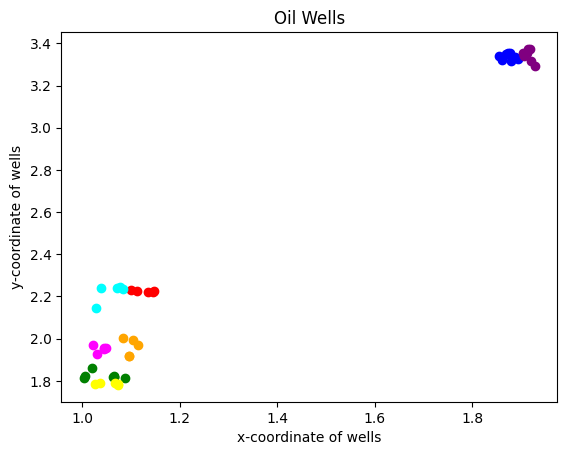

In [29]:
color_list_oil = get_cluster_colors(len(selected_oil.groupby("Project")), pd.unique(selected_oil["Project"]))

oil_figure = plt.figure()
ax1 = oil_figure.add_subplot(111)

for cluster in color_list_oil:
    oil_cluster = selected_oil[selected_oil["Project"] == cluster]
    ax1.scatter(oil_cluster["Latitude"], oil_cluster["Longitude"], c=color_list_oil[cluster])
plt.title('Oil Wells')
plt.xlabel('x-coordinate of wells')
plt.ylabel('y-coordinate of wells')
plt.show()

In [30]:
for i in grouped_oil['Project ID']:
    print(f"The following wells are in {i}")
    cluster = int(i[7:])
    display(wells_in_project(selected_oil, cluster, new_df_oil))

The following wells are in Project 100


,Project,API Well Number,Operator Name,Gas [Mcf/Year],Oil [bbl/Year],Age [Years],Depth [ft],Priority Score [0-100],Project Efficiency Score [0-100]
0,100,44388,Owner 137,0.00,0.00,139,11323,77.03,49.27
1,100,22370,Owner 194,22.39,5.01,144,4565,73.71,49.27
5,100,62214,Owner 117,0.40,4.56,136,2192,70.28,49.27
30,100,53671,Owner 99,3.61,8.53,141,3092,64.48,49.27
79,100,86587,Owner 54,0.00,9.27,90,3926,61.27,49.27


The following wells are in Project 52


,Project,API Well Number,Operator Name,Gas [Mcf/Year],Oil [bbl/Year],Age [Years],Depth [ft],Priority Score [0-100],Project Efficiency Score [0-100]
18,52,80939,Owner 21,0.00,0.00,143,4989,65.87,43.99
23,52,34779,Owner 249,0.00,0.00,140,1937,65.13,43.99
32,52,13511,Owner 181,0.00,7.85,131,9155,64.08,43.99
48,52,27532,Owner 85,36.22,38.17,124,6631,63.33,43.99
58,52,33196,Owner 202,0.00,9.32,115,4719,62.44,43.99


The following wells are in Project 55


,Project,API Well Number,Operator Name,Gas [Mcf/Year],Oil [bbl/Year],Age [Years],Depth [ft],Priority Score [0-100],Project Efficiency Score [0-100]
4,55,36524,Owner 238,30.70,11.83,112,415,70.93,40.89
25,55,95853,Owner 24,0.00,0.00,124,9369,64.86,40.89
100,55,89482,Owner 79,6.50,10.00,73,5409,59.73,40.89
147,55,37553,Owner 235,5.77,8.15,100,7145,58.07,40.89
163,55,80044,Owner 177,0.00,0.00,57,5011,57.41,40.89


The following wells are in Project 58


,Project,API Well Number,Operator Name,Gas [Mcf/Year],Oil [bbl/Year],Age [Years],Depth [ft],Priority Score [0-100],Project Efficiency Score [0-100]
3,58,21133,Owner 53,0.00,4.40,148,4199,71.70,44.21
10,58,97973,Owner 168,6.76,18.72,147,6845,66.81,44.21
16,58,83353,Owner 1,0.00,7.70,132,8906,66.30,44.21
19,58,32031,Owner 78,2.84,4.79,132,1563,65.57,44.21
21,58,32138,Owner 20,0.00,0.44,128,4531,65.26,44.21
39,58,99999,Owner 84,0.00,34.43,103,6957,63.75,44.21
40,58,68291,Owner 176,3.05,10.62,107,12598,63.72,44.21
41,58,80955,Owner 87,0.00,8.28,141,11185,63.70,44.21


The following wells are in Project 62


,Project,API Well Number,Operator Name,Gas [Mcf/Year],Oil [bbl/Year],Age [Years],Depth [ft],Priority Score [0-100],Project Efficiency Score [0-100]
2,62,55133,Owner 97,0.76,4.83,128,9581,71.81,51.32
11,62,60408,Owner 191,31.23,27.70,73,10985,66.71,51.32
13,62,68269,Owner 164,6.67,5.93,111,183,66.56,51.32
20,62,85318,Owner 102,0.00,66.33,98,9605,65.32,51.32
22,62,27793,Owner 98,9.68,20.49,124,8584,65.25,51.32
24,62,56420,Owner 151,2.85,6.45,85,11709,65.10,51.32
27,62,27016,Owner 108,0.00,40.96,47,1191,64.57,51.32
34,62,38361,Owner 163,124.16,171.65,101,9009,63.97,51.32
35,62,30327,Owner 239,1.07,31.96,55,11665,63.96,51.32
36,62,73136,Owner 230,0.00,0.23,107,7046,63.94,51.32


The following wells are in Project 72


,Project,API Well Number,Operator Name,Gas [Mcf/Year],Oil [bbl/Year],Age [Years],Depth [ft],Priority Score [0-100],Project Efficiency Score [0-100]
6,72,38073,Owner 154,35.35,29.59,106,3429,68.17,48.62
8,72,57746,Owner 33,0.00,0.74,100,7960,67.43,48.62
26,72,86039,Owner 123,0.00,4.54,33,11903,64.70,48.62
33,72,63111,Owner 233,9.71,6.97,109,3552,63.99,48.62
43,72,87307,Owner 68,0.00,2.54,96,4886,63.50,48.62
45,72,16280,Owner 41,2.06,9.24,86,8947,63.42,48.62
56,72,85997,Owner 160,0.00,7.28,112,9879,62.58,48.62


The following wells are in Project 75


,Project,API Well Number,Operator Name,Gas [Mcf/Year],Oil [bbl/Year],Age [Years],Depth [ft],Priority Score [0-100],Project Efficiency Score [0-100]
29,75,85330,Owner 129,6.15,32.22,141,8764,64.53,57.24
37,75,90932,Owner 209,9.70,3.35,140,11427,63.94,57.24
49,75,53474,Owner 219,2.81,8.16,143,10542,63.12,57.24
55,75,71173,Owner 120,0.00,35.58,143,10805,62.62,57.24
63,75,56795,Owner 229,16.07,28.50,93,12550,61.94,57.24


The following wells are in Project 87


,Project,API Well Number,Operator Name,Gas [Mcf/Year],Oil [bbl/Year],Age [Years],Depth [ft],Priority Score [0-100],Project Efficiency Score [0-100]
9,87,27084,Owner 104,0.00,17.14,139,3898,66.84,50.06
12,87,68325,Owner 76,0.00,7.81,143,5509,66.63,50.06
15,87,88574,Owner 134,6.62,8.90,118,9714,66.35,50.06
38,87,43064,Owner 52,19.45,44.81,107,10640,63.76,50.06
99,87,54483,Owner 173,7.11,7.72,59,8440,59.79,50.06


### Manual overrides for existing projects

PRIMO allows users to modify projects manually to satisfy requirements not considered above.



#### Gas wells

##### Select wells to be included in or excluded from the Recommended P&A Projects 

Please use the following widgets to select the wells:
- Top Widget: Select wells that should be included in the P&A projects. To confirm your selection, press the "Add the Well to the Suggested Projects" button.
- Bottom Widget: Select wells that should be removed from the recommended P&A projects. To confirm your selection, press the "Remove the Well from the Suggested Projects" button

If you need to exclude a well that has been selected, please use the "Undo" button associated to the corresponding widget.

In [31]:
def generate_summary(selected_wells,max_val_col,min_val_col,efficiency_weights):

    idx = -1
    resulting_contracts = []
    total_cost = 0
    grouped_contracts = []
    for cluster_id, groups in selected_wells.groupby("Project"):
        idx += 1
        n_wells = len(groups)
        campaign_cost = mobilization_costs[n_wells]
        total_cost += campaign_cost
        cluster = "Project " + cluster_id
        grouped_contracts += [[cluster, f"{campaign_cost:,}", n_wells]]
        for _, row in groups.iterrows():
            new_row = [cluster, row["API Well Number"], f"{campaign_cost:,}", n_wells]
            resulting_contracts += [new_row]

    results = pd.DataFrame(
        resulting_contracts,
        columns=[
            "Project ID",
            "API Well Number",
            "Estimated Project Cost",
            "Wells in Campaign",
        ],
    )


    ###Efficiency calculation

    wells = selected_wells[['API Well Number', 'Operator Name', 'Age [Years]', 'Depth [ft]', 'Latitude', 'Longitude', 'Priority Score [0-100]', 'Project', "Distance to Road [miles]",
            "Elevation Delta [m]",]]

    wells = wells.sort_values(by='Project')

    cluster_groups = wells.groupby('Project')

    centroids = {}

    # Iterate over each cluster group
    for cluster, group in cluster_groups:
        centroid = tuple(np.round(np.mean(group[['Latitude', 'Longitude']].values, axis=0), 6))
        centroids[cluster] = centroid

    # Create a new column 'Cluster Centroid' by mapping the centroids dictionary
    wells['Project Centroid'] = wells['Project'].map(centroids)

    wells['Distance to Centroid [miles]'] = wells.apply(lambda row: get_distance((row['Latitude'], row['Longitude']), row['Project Centroid']), axis=1)

    new_df = process_data(wells, centroids)
    cols_to_display = list(new_df.columns)

    cols_to_display.remove("Impact Score [0-100]")

    cols_to_display = ["Project", "Project Centroid"]

    new_df["Efficiency Score [0-100]"] = 0
    # Convert all criterion to scores
    for col in criterion & efficiency_weights.keys():
        
        if col in ["Number of Wells"]:
            new_df[f"{col} Score [0 - {efficiency_weights[col]}]"] = (new_df[col] - min_val_col[col]) * efficiency_weights[col] / (max_val_col[col] - min_val_col[col])
            cols_to_display.append(f"{col} Score [0 - {efficiency_weights[col]}]")
        if col in [
        "Average Elevation Delta [m]",  
        "Average Distance to Road [miles]", 
        "Distance to Centroid [miles]",  
        "Age Range [Years]", 
        "Average Age [Years]",  
        "Depth Range [ft]",
        "Average Depth [ft]",
        "Number of Unique Owners" 
    ]:
            new_df[f"{col} Score [0 - {efficiency_weights[col]}]"] = (max_val_col[col] - new_df[col]) * efficiency_weights[col] / (max_val_col[col] - min_val_col[col])
            cols_to_display.append(f"{col} Score [0 - {efficiency_weights[col]}]")
        
        new_df = new_df.apply(lambda row: reset_scores_if_single_well(row, col), axis=1)
        new_df = new_df.apply(lambda row: reset_scores_if_average_is_nan(row, col), axis=1)
        new_df["Efficiency Score [0-100]"] += new_df[f"{col} Score [0 - {efficiency_weights[col]}]"]

    acc_criterion = ["Average Elevation Delta [m]",  "Average Distance to Road [miles]",]
    ac_weight = 0
    for ac_col in acc_criterion & efficiency_weights.keys():
        ac_weight += efficiency_weights[ac_col]
    new_df[f'Accessibility Score [0 - {ac_weight}]'] = 0
    for ac_col in acc_criterion & efficiency_weights.keys():
        new_df[f'Accessibility Score [0 - {ac_weight}]'] += new_df[f'{ac_col} Score [0 - {efficiency_weights[ac_col]}]']
        cols_to_display.remove(f"{ac_col} Score [0 - {efficiency_weights[ac_col]}]")
    if ac_weight > 0:
        cols_to_display.append(f'Accessibility Score [0 - {ac_weight}]')

    cols_to_display.append("Efficiency Score [0-100]")

    new_df = new_df.sort_values(by="Efficiency Score [0-100]", ascending=False)


    grouped = pd.DataFrame(
        grouped_contracts,
        columns=["Project ID", "Estimated Project Cost", "Wells in Project"],
    )

    blankIndex=[''] * len(new_df)
    new_df.index=blankIndex
    return new_df,cols_to_display,grouped,total_cost

In [32]:
import pandas as pd
from primo.utils.config_utils import SelectWidget
from IPython.display import Javascript, display


unselected_gas = gas_gdf[gas_gdf["selected"] == "0"]
well_list_add_gas = SelectWidget(unselected_gas["API Well Number"].astype(str), "Select wells to manually add", "Well")
well_list_remove_gas = SelectWidget(selected_gas["API Well Number"].astype(str), "Select wells to manually remove", "Well")


well_list_add_gas.display()
well_list_remove_gas.display()

Combobox(value='', description='Well', placeholder='Select Well')

Combobox(value='', description='Well', placeholder='Select Well')

In [33]:
from primo.utils.override_utils import Recalculate
well_add_list_gas = well_list_add_gas.return_selections()
display(Markdown("These wells have been added to the recommended projects"))
display(well_list_add_gas.return_selections())
well_remove_list_gas = well_list_remove_gas.return_selections()
display(Markdown("These wells have been excluded from the recommended projects"))
display(well_list_remove_gas.return_selections())

These wells have been added to the recommended projects

[]

These wells have been excluded from the recommended projects

[]

##### Results based on the User-input Override Lists

In [34]:
violation_gas = Recalculate(selected_gas, well_add_list_gas, well_remove_list_gas,gas_gdf,opt_inputs_gas)

violate_cost_gas=violation_gas.assess_budget()
violate_operator_gas=violation_gas.assess_owner_well_count()
violate_distance_gas=violation_gas.assess_distances()

if violate_cost_gas > 0:
    display(Markdown(f""" After the modification, the total budget is ${int(violate_cost_gas)}, which is over the budget limit 
                     ${gas_budget}. Please consider modifying wells you have selected by either using the widget above or by re-running the optimization problem."""))

if violate_operator_gas:
    display(Markdown(f""" After the modification, the following owners have more than {max_wells_per_owner} well(s) 
                     being selected. Please consider modifying wells you have selected by either using the widget above or by re-running
                     the optimization problem."""))
    violate_operator_gas_df = pd.DataFrame.from_dict(violate_operator_gas,orient='index')
    violate_operator_gas_df = violate_operator_gas_df.reset_index()
    violate_operator_gas_df = violate_operator_gas_df.rename(columns={'index': 'Owner', 0: 'Number of wells', 1: 'Wells'})
    display(violate_operator_gas_df)


if violate_distance_gas:
    display(Markdown(""" After the modification, the following projects have wells are far away from each others. 
                     Please consider modifying wells you have selected by either using the widget above or by 
                     re-running the optimization problem."""))
    violate_distance_gas_df = pd.DataFrame.from_dict(violate_distance_gas,orient='index')
    violate_distance_gas_df = violate_distance_gas_df.reset_index(drop=True)
    violate_distance_gas_df = violate_distance_gas_df.rename(columns={0: 'Project', 1: 'Well 1', 2: 'Well 2', 3: "Distance between Well 1 and 2 [Miles]"})
    display(violate_distance_gas_df)

new_df_or_gas,cols_to_display,grouped_or_gas,total_cost_or_gas=generate_summary(violation_gas._plugged_list,max_val_col,min_val_col,efficiency_weights)
display(Markdown(""" A summary of the results based on the override well list selected"""))
if violation_gas.assess_feasibility():
    display(Markdown(""" Project Status: FEASIBLE"""))
else:
    display(Markdown(""" Project Status: INFEASIBLE"""))
display(new_df_or_gas[["Project", "Number of Wells", "Impact Score [0-100]", "Efficiency Score [0-100]"]])
print(f"Total budget recommended for plugging gas wells is: {total_cost_or_gas:,}")

 A summary of the results based on the override well list selected

 Project Status: FEASIBLE

,Project,Number of Wells,Impact Score [0-100],Efficiency Score [0-100]
,2,17,67.23,53.57
,18,6,66.25,52.43
,9,5,64.26,43.73
,14,5,64.62,42.58
,5,5,63.41,40.90


Total budget recommended for plugging gas wells is: 3,192,000


##### Well Suggestions for backfill

If as a result of manual overrides there is a possibility of adding new wells to the plugging projects, PRIMO can make suggestions for new wells to be included!

In [35]:
if violation_gas.assess_feasibility() is False:
    display(
        Markdown(
            f""" No backfill candidates can be generated due to infeasibility. Please re-optimize"""
            )
        )

else:
    well_ids_backfill = violation_gas.backfill()
    if not well_ids_backfill:
        display(
            Markdown(
                f""" No backfill candidates can be generated. Please re-optimize"""
                )
            )
    else:
        print("Following wells have been identified as good candidates for backfilling")
        
        data = []
        for well_id in well_ids_backfill:
            project = gas_gdf[gas_gdf["API Well Number"] == well_id]["Project"].iloc[0]
            data.append([well_id, project])
        display(pd.DataFrame(data, columns=["API Well Number", "Project"]))
            
        new_df_or_gas,cols_to_display,grouped_or_gas,total_cost_or_gas=generate_summary(violation_gas._plugged_list,max_val_col,min_val_col,efficiency_weights)
        display(Markdown(""" A summary of the results based on backfilled wells is below."""))
        display(Markdown(""" Project Status: FEASIBLE"""))
        display(new_df_or_gas[["Project", "Number of Wells", "Impact Score [0-100]", "Efficiency Score [0-100]"]])
        print(f"Total budget recommended for plugging gas wells is: {total_cost_or_gas:,}")

 No backfill candidates can be generated. Please re-optimize

#### Oil wells

##### Select wells to be included in or excluded from the Recommended P&A Projects 

Please use the following widgets to select the wells:
- Top Widget: Select wells that should be included in the P&A projects. To confirm your selection, press the "Select Wells to Manually Add" button.
- Bottom Widget: Select wells that should be removed from the recommended P&A projects. To confirm your selection, press the "Select Wells to Manually Remove" button

If you need to exclude a well that has been selected, please use the "Undo" button associated to the corresponding widget.

In [36]:
import pandas as pd
from primo.utils.config_utils import SelectWidget
from IPython.display import Javascript, display


unselected_oil = oil_gdf[oil_gdf["selected"] == "0"]
well_list_add_oil = SelectWidget(unselected_oil["API Well Number"].astype(str), "Select wells to manually add", "Well")
well_list_remove_oil = SelectWidget(selected_oil["API Well Number"].astype(str), "Select wells to manually remove", "Well")


well_list_add_oil.display()
well_list_remove_oil.display()

Combobox(value='', description='Well', placeholder='Select Well')

Combobox(value='', description='Well', placeholder='Select Well')

In [37]:
from primo.utils.override_utils import Recalculate
well_add_list_oil = well_list_add_oil.return_selections()
display(Markdown("These wells have been added to the recommended projects"))
display(well_list_add_oil.return_selections())
well_remove_list_oil = well_list_remove_oil.return_selections()
display(Markdown("These wells have been excluded from the recommended projects"))
display(well_list_remove_oil.return_selections())

These wells have been added to the recommended projects

[]

These wells have been excluded from the recommended projects

[]

##### Results based on the User-input Override Lists

In [38]:
violation_oil = Recalculate(selected_oil, well_add_list_oil, well_remove_list_oil,oil_gdf,opt_inputs_oil)

violate_cost_oil=violation_oil.assess_budget()
violate_operator_oil=violation_oil.assess_owner_well_count()
violate_distance_oil=violation_oil.assess_distances()

if violate_cost_oil > 0:
    display(Markdown(f""" After the modification, the total budget is over the limit by ${int(violate_cost_oil)}.
                     Please consider modifying wells you have selected by either using the widget above or by re-running the optimization problem."""))

if bool(violate_operator_oil) is not False:
    display(Markdown(f""" After the modification, the following owners have more than {max_wells_per_owner} well(s) 
                     being selected. Please consider modifying wells you have selected by either using the widget above or by 
                     re-running the optimization problem."""))
    violate_operator_oil_df = pd.DataFrame.from_dict(violate_operator_oil,orient='index')
    violate_operator_oil_df = violate_operator_oil_df.reset_index()
    violate_operator_oil_df = violate_operator_oil_df.rename(columns={'index': 'Owner', 0: 'Number of wells', 1: 'Wells'})
    display(violate_operator_oil_df)


if bool(violate_distance_oil) is not False:
    display(Markdown(f""" After the modification, the following projects have wells are far away from each others. 
                     Please consider modifying wells you have selected by either using the widget above 
                     or by re-running the optimization problem."""))
    violate_distance_oil_df = pd.DataFrame.from_dict(violate_distance_oil,orient='index')
    violate_distance_oil_df = violate_distance_oil_df.reset_index(drop=True)
    violate_distance_oil_df = violate_distance_oil_df.rename(columns={0: 'Project', 1: 'Well 1', 2: 'Well 2', 3: "Distance between Well 1 and 2 [Miles]"})
    display(violate_distance_oil_df)



new_df_or_oil,cols_to_display,grouped_or_oil,total_cost_or_oil=generate_summary(violation_oil._plugged_list,max_val_col,min_val_col,efficiency_weights)
display(Markdown(""" A summary of the results based on the override well list selected"""))
if violation_oil.assess_feasibility():
    display(Markdown(""" Project Status: FEASIBLE"""))
else:
    display(Markdown(""" Project Status: INFEASIBLE"""))
display(new_df_or_oil[["Project", "Number of Wells", "Impact Score [0-100]", "Efficiency Score [0-100]"]])
print(f"Total budget recommended for plugging oil wells is: {total_cost_or_oil:,}")

 A summary of the results based on the override well list selected

 Project Status: FEASIBLE

,Project,Number of Wells,Impact Score [0-100],Efficiency Score [0-100]
,75,5,63.23,57.24
,62,11,65.45,51.32
,87,5,64.67,50.06
,100,5,69.35,49.27
,72,7,64.83,48.62
,58,8,65.85,44.21
,52,5,64.17,43.99
,55,5,62.20,40.89


Total budget recommended for plugging oil wells is: 4,284,000


##### Well Suggestions for backfill

If as a result of manual overrides there is a possibility of adding new wells to the plugging projects, PRIMO can make suggestions for new wells to be included!

In [39]:
if violation_oil.assess_feasibility() is False:
    display(
        Markdown(
            f""" No backfill candidates can be generated due to infeasibility. Please re-optimize"""
            )
        )

else:
    well_ids_backfill = violation_oil.backfill()
    if not well_ids_backfill:
        display(
            Markdown(
                f""" No backfill candidates can be generated. Please re-optimize"""
                )
            )
    else:
        print("Following wells have been identified as good candidates for backfilling")
        
        data = []
        for well_id in well_ids_backfill:
            project = oil_gdf[oil_gdf["API Well Number"] == well_id]["Project"].iloc[0]
            data.append([well_id, project])
        display(pd.DataFrame(data, columns=["API Well Number", "Project"]))
            
        new_df_or_oil,cols_to_display,grouped_or_oil,total_cost_or_oil=generate_summary(violation_gas._plugged_list,max_val_col,min_val_col,efficiency_weights)
        display(Markdown(""" A summary of the results based on backfilled wells is below."""))
        display(Markdown(""" Project Status: FEASIBLE"""))
        display(new_df_or_oil[["Project", "Number of Wells", "Impact Score [0-100]", "Efficiency Score [0-100]"]])
        print(f"Total budget recommended for plugging gas wells is: {total_cost_or_oil:,}")

 No backfill candidates can be generated. Please re-optimize

#### Select Final Results

Users can choose to keep (1) the original solutions obtained from solving the optimization initially; (2) the solutions obtained based on the override well lists.

# Capability 3: P&A Project Efficiency Assessments
Ideal P&A projects not only include (many) high-priority wells but also prioritize the efficient use of available resources (e.g., budget, crews, equipment, ...). PRIMO has been designed to quantify the expected IMPACT and EFFICIENCY of recommended P&A candidate projects.

We employ a series of user-defined functions to calculate essential KPIs for each proposed P&A project.

- **Number of Wells**: The more wells a P&A project includes, the the more efficient plugging operations are expected to be - especially if the respective wells are close to each other. Note that upper limits on the number of wells per project may be imposed. Counted as the total number of wells associated with each project.

- **Well Proximities**: This KPI quantifies the "compactness" of any given P&A project. Wells close to each other lead to efficient plugging projects (e.g., reduced mobilization costs/efforts). Defined as the average absolute distance from well locations to the centroid of the project cluster.

- **Well Accessibility - Road Access**: The distance of any well to the closest road access point is used as a measure of well accessibility. The further a well is from any established road, the most costly it is presumed the P&A operation will be. Road construction cost can be significant contributor to project costs and efforts. Measured as the average absolute distance from well locations to their nearest road point. 

- **Well Accessibility - Elevation Change**: This KPI attempts to assess the accessibility of wells by comparing the elevation of the closest road access points to the elevation of the wells contained in a P&A project. If multiple wells in a project are characterized by significant elevation changes, they are presumed to be less accessible which increases P&A costs leading to inefficiencies. Computed as the average absolute elevation delta across all wells within the project group. The elevation delta is referred as the difference in surface elevation of the well and the elevation of the closest road access point. 

- **Well Characteristics - Age Range**: Wells with similar characteristics make for efficient P&A projects. As such, significant differences in well ages within a P&A project can pose challenges to P&A operations. The closer wells are in terms of age, the more efficient a P&A project is presumed to be. This metric Determined by subtracting the minimum age from the maximum age of wells within each P&A project. 

- **Well Characteristics - Depth Range**: Significant differences in well depths within a P&A project can pose challenges to P&A operations. The closer the wells are in terms of depth, the more efficient a P&A project is presumed to be. Calculated as the difference between the maximum and minimum depths of wells within the cluster. 

- **Number of Unique Well Owners**: As the number of (unique) well owners included in a given P&A project increases, so does the effort to manage a given project. Captured by counting the number of distinct company names associated with wells within each project. 

Upon computation of the KPIs for each P&A project, the next step is to scale these raw KPI values into standardized scores between 0 - 100 and then take the weighted average to calculate the **Efficiency Score** of the projects. 

## Efficiency Metrics for P&A Gas Projects

We calculate selected efficiency metrics for each plugging project:

In [40]:
display(new_df_gas[cols_to_display])

,Project,Project Centroid,Age Range [Years] Score [0 - 5],Average Age [Years] Score [0 - 0],Number of Unique Owners Score [0 - 0],Average Depth [ft] Score [0 - 5],Depth Range [ft] Score [0 - 20],Distance to Centroid [miles] Score [0 - 30],Number of Wells Score [0 - 20],Accessibility Score [0 - 20],Efficiency Score [0-100]
,2,"(1.894881, 3.3324)",1.68,0.00,0.00,2.59,0.33,18.91,20.00,10.07,53.57
,18,"(1.059728, 2.235942)",3.02,0.00,0.00,3.37,9.61,21.50,6.25,8.68,52.43
,9,"(1.083772, 2.18016)",2.82,0.00,0.00,2.43,7.34,17.48,5.00,8.65,43.73
,14,"(1.106335, 1.985986)",1.07,0.00,0.00,2.47,4.78,18.44,5.00,10.82,42.58
,5,"(1.024886, 1.916272)",3.36,0.00,0.00,2.75,4.97,17.76,5.00,7.07,40.90


Scaling these raw KPI values into standardized scores between 0 - 100 and taking the weighted average to calculate the **Efficiency Score** of the projects.

The final IMPACT and EFFICIENCY scores of the gas plugging projects are shown below:

In [41]:
blankIndex=[''] * len(new_df_gas)
new_df_gas.index=blankIndex

display(new_df_gas[["Project", "Number of Wells", "Impact Score [0-100]", "Efficiency Score [0-100]"]])

,Project,Number of Wells,Impact Score [0-100],Efficiency Score [0-100]
,2,17,67.23,53.57
,18,6,66.25,52.43
,9,5,64.26,43.73
,14,5,64.62,42.58
,5,5,63.41,40.90


## Efficiency Metrics for P&A Oil Projects

We calculate selected efficiency metrics for each plugging project:

In [42]:
display(new_df_oil[cols_to_display])

,Project,Project Centroid,Age Range [Years] Score [0 - 5],Average Age [Years] Score [0 - 0],Number of Unique Owners Score [0 - 0],Average Depth [ft] Score [0 - 5],Depth Range [ft] Score [0 - 20],Distance to Centroid [miles] Score [0 - 30],Number of Wells Score [0 - 20],Accessibility Score [0 - 20],Efficiency Score [0-100]
,75,"(1.037371, 1.952162)",3.36,0.00,0.00,0.84,14.20,23.87,5.00,9.97,57.24
,62,"(1.876592, 3.337475)",2.21,0.00,0.00,1.95,2.27,23.34,12.50,9.04,51.32
,87,"(1.055604, 1.784943)",2.21,0.00,0.00,2.06,9.64,22.05,5.00,9.09,50.06
,100,"(1.12774, 2.225118)",3.22,0.00,0.00,3.07,5.96,22.79,5.00,9.22,49.27
,72,"(1.915263, 3.343775)",2.38,0.00,0.00,2.23,6.97,19.93,7.50,9.61,48.62
,58,"(1.046962, 1.823161)",3.52,0.00,0.00,2.27,3.03,17.32,8.75,9.32,44.21
,52,"(1.060575, 2.222222)",4.09,0.00,0.00,2.89,8.91,14.30,5.00,8.79,43.99
,55,"(1.098993, 1.960478)",2.79,0.00,0.00,2.90,6.23,14.76,5.00,9.22,40.89


Scaling these raw KPI values into standardized scores between 0 - 100 and taking the weighted average to calculate the **Efficiency Score** of the projects.

The final IMPACT and EFFICIENCY scores of the oil plugging projects are shown below:

In [43]:
blankIndex=[''] * len(new_df_oil)
new_df_oil.index=blankIndex

display(new_df_oil[["Project", "Number of Wells", "Impact Score [0-100]", "Efficiency Score [0-100]"]])

,Project,Number of Wells,Impact Score [0-100],Efficiency Score [0-100]
,75,5,63.23,57.24
,62,11,65.45,51.32
,87,5,64.67,50.06
,100,5,69.35,49.27
,72,7,64.83,48.62
,58,8,65.85,44.21
,52,5,64.17,43.99
,55,5,62.20,40.89


## Saving PRIMO Results

We save the gas well and oil well projects in an excel file for each run. The default file name for the run is "Primo_Projects.xlsx".

In [44]:
efficiency_dict = new_df_gas.set_index('Project')['Efficiency Score [0-100]'].to_dict()
selected_gas['Efficiency Score [0-100]'] = selected_gas['Project'].map(efficiency_dict)

efficiency_dict = new_df_oil.set_index('Project')['Efficiency Score [0-100]'].to_dict()
selected_oil['Efficiency Score [0-100]'] = selected_oil['Project'].map(efficiency_dict)

def wells_in_project_result(df, project_id):
    subset = df[(df["Project"] == f"{project_id}") & (df["selected"] == "1")]
    cols_to_keep = [
        "Project",
        "API Well Number",
        "Operator Name",
        "Priority Score [0-100]",
        "Efficiency Score [0-100]",
        "Gas [Mcf/Year]",
        "Oil [bbl/Year]",
        "Age [Years]",
        "Depth [ft]",
        'Latitude',
        'Longitude', 
        'Incident [Yes/No]', 'Violation [Yes/No]',
        'Compliance [Yes/No]', 'Leak [Yes/No]',
    ]
    try:
        school_file
        cols_to_keep+=['Schools Within Distance']
    except NameError:
        cols_to_keep = cols_to_keep
    try:
        hospital_file
        cols_to_keep+=['Hospitals Within Distance']
    except NameError:
        cols_to_keep = cols_to_keep
    subset = subset[cols_to_keep]
    subset = subset.rename(columns={"Priority Score [0-100]": "Well Priority Score [0-100]"})
    return subset

def write_projects_to_excel(writer, projects, sheet_name, data, start_row=0):
    for project_id in projects:
        cluster = int(project_id[7:])
        wells_df = wells_in_project_result(data, cluster)
        wells_df.to_excel(writer, sheet_name=sheet_name, startrow=start_row, startcol=0, index=False)
        start_row += len(wells_df) + 2  # Add one line spacing after each table



# Rename columns in new_df_gas and new_df_oil before writing to Excel
new_df_gas = new_df_gas.rename(columns={"Efficiency Score [0-100]": "Project Efficiency Score [0-100]"})
new_df_oil = new_df_oil.rename(columns={"Efficiency Score [0-100]": "Project Efficiency Score [0-100]"})

# Assuming grouped_gas, grouped_oil, selected_gas, selected_oil, new_df_gas, and new_df_oil are defined
excel_writer = pd.ExcelWriter(config_dict.get("Output file"), engine='xlsxwriter')

# Write gas well projects to 'Gas projects scores' sheet
new_df_gas[["Project", "Number of Wells", "Impact Score [0-100]", "Project Efficiency Score [0-100]"]].to_excel(excel_writer, sheet_name='Gas Project Scores', index=False)

# Write oil well projects to 'Oil projects scores' sheet
new_df_oil[["Project", "Number of Wells", "Impact Score [0-100]", "Project Efficiency Score [0-100]"]].to_excel(excel_writer, sheet_name='Oil Project Scores', index=False)

# Write gas well projects to 'Gas well projects' sheet
write_projects_to_excel(excel_writer, grouped_gas['Project ID'], 'Gas well projects', selected_gas)

# Write oil well projects to 'Oil well projects' sheet
write_projects_to_excel(excel_writer, grouped_oil['Project ID'], 'Oil well projects', selected_oil)


excel_writer.close()
